In [2]:
import pandas as pd
import shap

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [4]:
dataset = pd.read_csv('data/train.csv')

features = ['Sex', 'Age', 'Fare']
label = ['Survived']

dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Preprocess the data
train_data = dataset[['PassengerId', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
train_data = train_data.set_index(['PassengerId'])
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
# Train the model
X_train = train_data[features]
y_train = train_data['Survived']

model = RandomForestClassifier(max_depth=3)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

In [6]:
X_train_aux = X_train.reset_index().reset_index()

In [7]:
y_train.mean()

0.4061624649859944

In [8]:
def create_tree_shap(X, tree):
    explainer_tree = shap.Explainer(tree)
    return explainer_tree(X)

shap_v_rf = create_tree_shap(X_train, model)

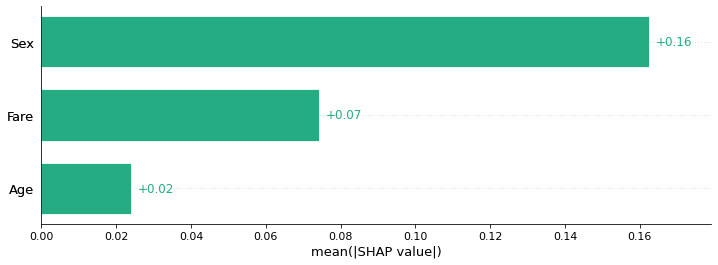

In [11]:
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


f = 1
shap.plots.bar(shap_v_rf[:, :, 1], show=False)  # Do not auto-show

fig = plt.gcf()         # Get current figure
fig.set_size_inches(12*f, 4*f)  # Resize it

# Change bar colors
ax = plt.gca()
for bar in ax.patches:
    bar.set_facecolor('#25AC82')

# Change label colors
for text in ax.texts:
    text.set_color('#25AC82')
    
fig.savefig("figs/shap_barplot.png", dpi=300, bbox_inches='tight')  # or .pdf, .svg, etc.
plt.show()

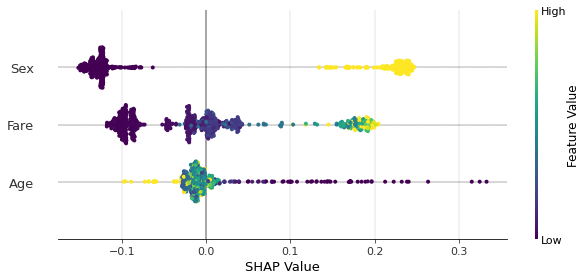

In [12]:
f = 0.8
fig, ax = plt.subplots()
shap.summary_plot(
    shap_v_rf[:,:,1], max_display=6, show=False,
#     plot_type="violin",
    cmap='viridis',
    plot_size = (11*f, 5*f)
)
fig.axes[-1].set_ylabel('Feature Value', color='black')

ax.grid(color='black', linestyle='-', axis='x', linewidth=.1)
ax.grid(color='black', linestyle='-', axis='y', linewidth=.3)
ax.set_xlabel(f'SHAP Value')
fig.savefig("figs/shap_summary_plot.png", dpi=300, bbox_inches='tight')  # or .pdf, .svg, etc.
plt.show()

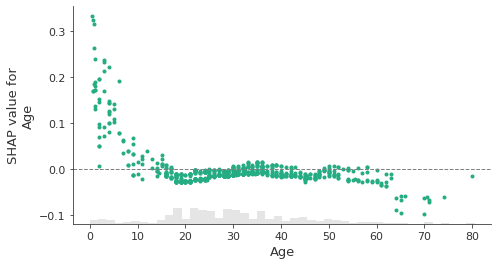

In [13]:
c = 'Age'
z = 0.5
fig, ax = plt.subplots(1, figsize=(15 * z, 8 * z))
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
shap.plots.scatter(shap_v_rf[:,c,1], 
                   ax=ax,
                   show=False,
                   hist=True,
                   color='#25AC82'
                  )
fig.savefig("figs/shap_dependence_scatter_plot.png", dpi=300, bbox_inches='tight')  # or .pdf, .svg, etc.
plt.show()

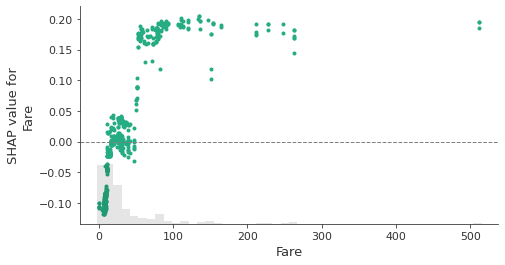

In [14]:
c = 'Fare'
z = 0.5
fig, ax = plt.subplots(1, figsize=(15 * z, 8 * z))
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
shap.plots.scatter(shap_v_rf[:,c,1], 
                   ax=ax,
                   show=False,
                   hist=True,
                   color='#25AC82'
                  )
fig.savefig("figs/shap_dependence_scatter_plot_fare.png", dpi=300, bbox_inches='tight')  # or .pdf, .svg, etc.
plt.show()

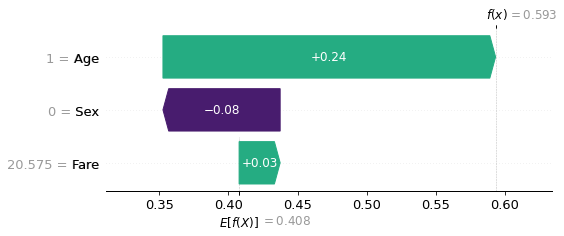

In [15]:
import matplotlib.pyplot as plt
import matplotlib
import shap

z = 0.8
id_obs = 628

fig, ax = plt.subplots(1, figsize=(15 * z, 8 * z))
shap.plots.waterfall(shap_v_rf[id_obs, :, 1], show=False)

# Default SHAP colors
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

# Custom colors
positive_color = "#25AC82"
negative_color = "#481C6E"

# Walk through the figure's children to adjust colors
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        # Arrows and bars
        if isinstance(fcc, matplotlib.patches.FancyArrow) or isinstance(fcc, matplotlib.patches.Rectangle):
            face = matplotlib.colors.to_hex(fcc.get_facecolor())
            if face == default_pos_color:
                fcc.set_facecolor(positive_color)
                fcc.set_edgecolor(positive_color)  # Remove red edge
            elif face == default_neg_color:
                fcc.set_facecolor(negative_color)
                fcc.set_edgecolor(negative_color)
        # Text labels
        elif isinstance(fcc, plt.Text):
            color = matplotlib.colors.to_hex(fcc.get_color())
            if color == default_pos_color:
                fcc.set_color(positive_color)
            elif color == default_neg_color:
                fcc.set_color(negative_color)

plt.savefig("figs/shap_waterfall_clean.png", dpi=300, bbox_inches='tight')
plt.show()

### Fairness

In [16]:
dataset['Female'] = dataset['Sex'].map({'male': 0, 'female': 1})
dataset['group'] = (dataset['Embarked'] == 'C').astype(int)

In [17]:
dataset.groupby('group')[['Age', 'Fare', 'Female', 'Survived']].mean()

,Age,Fare,Female,Survived
group,,,,
0,29.450771,25.756090,0.333333,0.344398
1,30.814769,59.954144,0.434524,0.553571


In [18]:
dataset.groupby('Embarked')['Fare'].mean()

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

In [19]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,1


In [27]:
import statsmodels.stats.api as sms
import seaborn as sns

colors_list = [
    '#25AC82',
    '#481C6E',
    '#E8D202',
    '#2F6B8E',
    '#5DA5DA',
    'white',
    '#C0C0C0',
    'grey',
    '#900C3F',
    '#581845',

]

def shapv2df(shap_values_raw):
    df_shap = pd.DataFrame(shap_values_raw[:,:,1].values, columns=shap_values_raw.feature_names)
    df_shap["pred"] = df_shap[shap_values_raw.feature_names].sum(axis=1)
    return df_shap

def shap_dif_in_means_feature(df, col, groups, random=False):
    if random:
        n = df.shape[0]
        v_bools = np.random.choice(a=[False, True], size=n)
        shap_c2_f = df[v_bools][col].values
        shap_c1_f = df[~v_bools][col].values
    else:
        v_bools = (groups - 0).astype(bool)
        shap_c2_f = df[v_bools][col].values
        shap_c1_f = df[~ v_bools][col].values
    print(col)
    print(shap_c1_f.mean())
    print(shap_c2_f.mean())
    cm = sms.CompareMeans(sms.DescrStatsW(shap_c2_f), sms.DescrStatsW(shap_c1_f))
    df = pd.DataFrame(cm.summary().data[1][1:], index=cm.summary().data[0][1:]).T.assign(feature=col)
    df["coef"] = df["coef"].astype(float)
    df["P>|t|"] = df["P>|t|"].astype(float)
    df["[0.025"] = df["[0.025"].astype(float)
    df["0.975]"] = df["0.975]"].astype(float)
    df["t"] = df["t"].astype(float)
    return df

def plot_dif_groups(df_plot, df_global, save=False):
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot individual confidence intervals and coefficients
    for lower, upper, coef, y in zip(df_plot['[0.025'], df_plot['0.975]'], df_plot['coef'], range(len(df_plot))):
        ax.plot((lower, upper), (y, y), linestyle='--', color=colors_list[0], alpha=0.6, linewidth=2)
        ax.plot(coef, y, 'o', color=colors_list[0], markersize=14, markeredgewidth=0)

    # Plot global coefficient
    y += 1
    ax.plot((df_global["[0.025"], df_global["0.975]"]), (y, y), linestyle='--', color=colors_list[1], alpha=0.6, linewidth=2)
    ax.plot(df_global["coef"], y, 'o', color=colors_list[1], markersize=16, markeredgewidth=0)

    # Y-axis labels
    labels = list(df_plot['feature']) + ["Global"]
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, fontsize=12)

    # X-axis config
    ax.axvline(0, color="grey", linestyle="-", linewidth=1.2)
    ax.set_xlabel(r'$| E(\phi\mid Cherbourg) - E(\phi\mid notCherbourg) |$', fontsize=14, color='black')
    ax.tick_params(axis='x', colors='black', labelsize=12)
    ax.tick_params(axis='y', colors='black')

    # Title
    ax.set_title("SHAP Geodemographic Disparity", fontsize=16, weight='bold', color='black', pad=20)

    # Grid & layout
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, color='gray', linestyle='dashed', alpha=0.3)
    sns.despine(trim=True)
    plt.savefig("figs/shap_disparity_plot.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    
def pipe_plot_dif(shap_value, modo, random=False, save=False):
    df_shap = shapv2df(shap_value, modo)
    df_dif_shap = pd.concat([shap_dif_in_means_feature(df_shap, c, df_region_shap.groups, random=random)  for c in shap_value.feature_names])
    df_plot = df_dif_shap.assign(abs_coef = abs(df_dif_shap["coef"].values)).dropna().sort_values("abs_coef").tail(10)
    df_plot['feature'] = df_plot['feature'].map(dict_map_feature)
    df_global = shap_dif_in_means_feature(df_shap, "pred", df_region_shap.groups, random=random)
    plot_dif_groups(df_plot, df_global, modo, save)

In [28]:
df_shap

,Sex,Age,Fare,pred
0,-0.129258,-0.022303,-0.099349,-0.250910
1,0.232159,0.009257,0.186782,0.428199
2,0.232882,-0.001607,-0.101464,0.129810
3,0.235389,0.015986,0.176461,0.427836
4,-0.120388,-0.008986,-0.090672,-0.220047
...,...,...,...,...
709,0.213853,-0.005738,0.005855,0.213970
710,-0.135994,-0.013807,-0.019120,-0.168921
711,0.215757,-0.011490,0.009064,0.213331
712,-0.126060,-0.009670,0.040510,-0.095221


In [29]:
df_x_embarked = pd.merge(
    X_train.reset_index(),
    dataset[['PassengerId', 'Embarked']],
    on=['PassengerId']
)

In [30]:
df_x_embarked['group'] = (df_x_embarked['Embarked'] == 'C').astype(int)

Sex
-0.006592474153898471
0.03431223709911297
Age
-0.0010083493659714248
0.0025247192961722026
Fare
-0.013271726967571689
0.06620793782381255
pred
-0.020872550487441584
0.10304489421909772


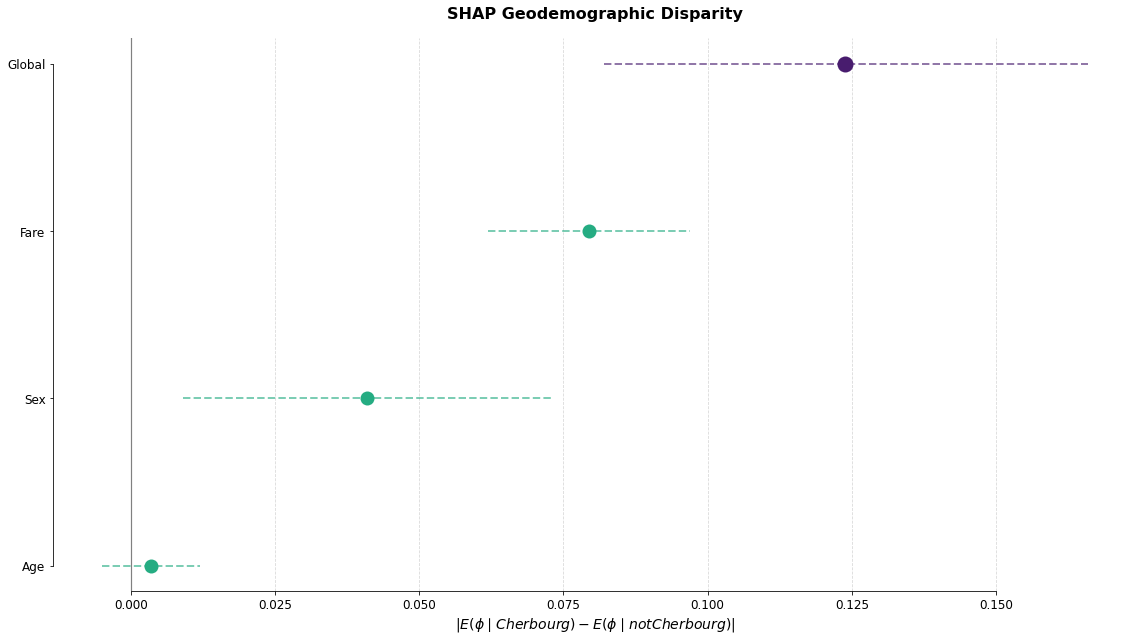

In [31]:
df_shap = shapv2df(shap_v_rf)
df_dif_shap = pd.concat([shap_dif_in_means_feature(df_shap, c, df_x_embarked.group, random=False)  for c in shap_v_rf.feature_names])
df_plot = df_dif_shap.assign(abs_coef = abs(df_dif_shap["coef"].values)).dropna().sort_values("abs_coef").tail(10)
df_global = shap_dif_in_means_feature(df_shap, "pred",  df_x_embarked.group, random=False)
plot_dif_groups(df_plot, df_global)